# 3. Missing data analysis

## Profile & imputation

Missing values are one of the most important behaviours to process while doing data science, nevertheless, the way we decide to deal with the present missingess afect the end results of the downstream applications.

There are different reasons for missing data, and before settling on any processing decision, we need to be sure and understand the missing data distribution so we can have it categorize:

- Missing completely at random **MCAR**
- Missing at random **MAR**
- Missing not at random **MNAR**

Furthermore different decisions behind the processing may affect the model differently:
- *Leave missing data*, this is visible whenever the percentage of missing data is small. In this cases, the missing values are treated as a category;
- *Delete missing data*, row-wise, can lead to the reduction of the statistical information available and it is problematic from small datasets;
- *Single imputation*, can be done using the mean, median or any other statistical property of the dataset. Can be done conditionally, but in general, ignores the relations with other variables which, reduces the overall dataset variability;
- *Model-based imputation*, this is by far the most complex, but also, the most efficient. Multiple models can be used, from KNN to forecasting models. Nevertheless, their effectiviness comes with the technical cost to have it implemented;

In [5]:
%%capture
!pip install miceforest

### Import the needed packages

In [6]:
import os
from enum import Enum

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

from ydata.metadata import Metadata

In [7]:
class ImputeMethod(Enum):
    DROP=0
    MEDIAN=1
    MULTIVARIATE=2

In [8]:
##Create a mask for each of the variables with missing data
def mask_missing(df: pd.DataFrame, cols: list) -> pd.DataFrame:
    aux = df.copy()
    for col in cols:
        aux[col+'_missing'] = pd.isna(aux[col]).astype('int')
    
    mask_columns = [col+'_missing' for col in cols]
    return aux, mask_columns

##Missing data heatmap
def heatmap_output(data: pd.DataFrame, title:str, cmap='Blues', annot=True):
    heatmap = sns.heatmap(data, annot=annot, cmap=cmap)
    plt.title(title, fontsize=16, pad=15)
    path = f"{title.replace(' ', '_')}.png"
    plt.savefig(path)
    html = f'<body><img src="{path}"></body>'
    print(html)
    return html

In [9]:
prep = {'Imputation': None, 'Drop Duplicates': False, 'Balancing': False}

In [10]:
t=os.getenv('IMPUTATION_STRATEGY')

In [11]:
try:
    label = os.environ['LABEL']
except:
    label = 'SeriousDlqin2yrs'
    
try:
    imputation = int(os.environ['IMPUTATION_STRATEGY'])
except:
    imputation = 1

## Reading the training dataset

In [12]:
data = pd.read_csv('train.csv', index_col=[0])

In [13]:
metadata = Metadata.load('metadata.pkl')
##Getting the variables with missing data
missing_col = [col for col, v in dict(metadata.summary['missings']).items() if v>0]

#Creating masking variables for the columns with identified missing data
data_mask, mask_cols = mask_missing(data, missing_col)

### In-depth missing data profiling

In [14]:
#Profile the missing base on the target variable
#There is no relevance of missing values based on the target
#This one can also be plotted
grouped_label = data_mask.groupby(label)[mask_cols]
missing_group = grouped_label.sum()/grouped_label.count()

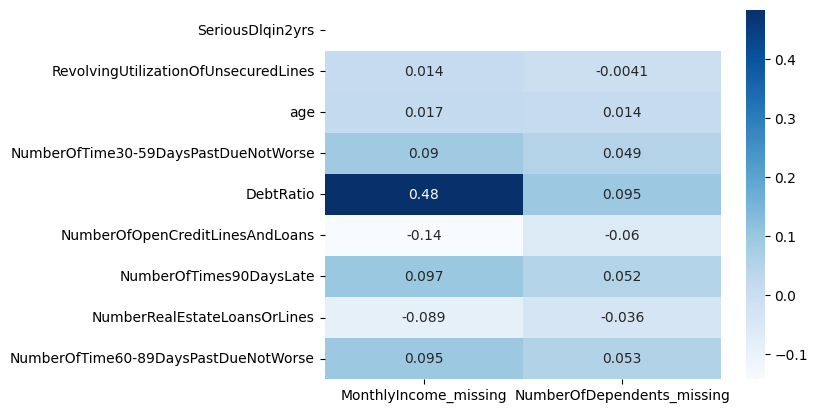

In [15]:
POS_data_mask = data_mask[data_mask[label]==1]
missing_pos_target = sns.heatmap(POS_data_mask.corr()[mask_cols].drop(missing_col+mask_cols), annot=True, cmap='Blues')
plt.savefig('missing_pos_heatmap.png')

## Imputation strategies

For the purpose of this pipeline, we have decided to implement and measure the impact of 3 different imputation strategies:

- Drop missing records
- Single impute with the median
- Model-based imputation

In [16]:
if imputation == 0:
    prep_data = data.dropna()
    imp = {}
elif imputation == 1:
    print('median0')
    from sklearn.impute import SimpleImputer
    imp = SimpleImputer(missing_values=np.nan, strategy='median')
    imp.fit(data)
    prep_data = pd.DataFrame(imp.transform(data), columns=data.columns)
elif imputation == 2:
    import miceforest as mf
    imp = mf.ImputationKernel(
          data,
          save_all_iterations=True,
          random_state=1991
        )
    # Run the MICE algorithm for 5 iterations
    imp.mice(5)
    #Add here or install the multivariate perspective
    prep_data = imp.complete_data(dataset=2)
    
prep['Imputation'] = imputation

median0


## Outputs

In [17]:
#Saving the outputs for the next step
prep_data.to_csv('prep_traindata.csv')
#Saving the imputer model
pickle.dump(imp, open('imputer.pkl', 'wb'))
#Saving the preparation parameters
pickle.dump(prep, open('prep_parameters.pkl', 'wb'))

### Creating the pipeline step outputs

<body><img src="Missing_correlation.png"></body>


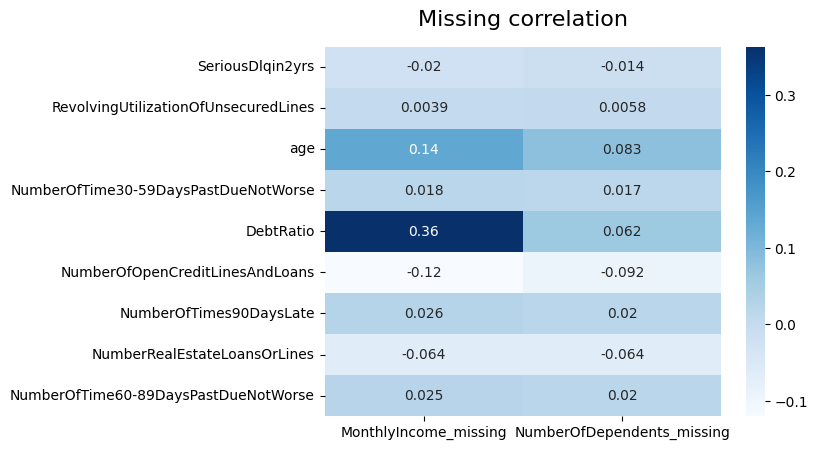

In [18]:
import json

html= f"<body><h1>Test</h1><p>{heatmap_output(data=data_mask.corr()[mask_cols].drop(missing_col+mask_cols), title='Missing correlation')}</p></body>"

metadata = {
    'outputs' : [
        {
          'type': 'table',
          'storage': 'inline',
          'format': 'csv',
          'header': list(missing_group.columns),
          'source': missing_group.to_csv(header=False, index=True)
        },
        {
          'type': 'markdown',
          'storage': 'inline',
          'source': f'## **Imputation method:** {ImputeMethod(imputation).name}',
        },
        {
      'type': 'markdown',
      'storage': 'inline',
      'source': '![Missing Values](Missing_correlation.png)',
    } 
    ]
  }

#heatmap_output(data=data_mask.corr()[mask_cols].drop(missing_col+mask_cols), title='Missing correlation')
with open('mlpipeline-ui-metadata.json', 'w') as metadata_file:
    json.dump(metadata, metadata_file)